# **One-pixel**

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import os
import random

In [2]:
ClassNames = ['Aircraft Carrier', 'Bulkers', 'Car Carrier', 'Container Ship', 'Cruise', 'DDG', 'Recreational', 'Sailboat', 'Submarine', 'Tug']

In [3]:
# Load and prepare the dataset
def load_data(data_image_path, data_label_path):
    data = []
    images = []
    labels = []
    
    for file in os.listdir(data_image_path):
        file_p = os.path.join(data_image_path, file)
        image = cv2.imread(file_p)
        image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
        images.append(image)
    
    for file in os.listdir(data_label_path):
        file_p = os.path.join(data_label_path, file)
        with open(file_p, "r") as f:
            label = int(f.read(1))
        labels.append(label)
    
    images = np.array(images) / 255.0
    labels = np.array(labels)
    
    return images, labels

In [4]:
# Define the CNN model
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    
    # Define a Dense layer with the correct number of units
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Load data
train_images, train_labels = load_data('/kaggle/input/ships-dataset/Ships dataset/train/images', '/kaggle/input/ships-dataset/Ships dataset/train/labels')
valid_images, valid_labels = load_data('/kaggle/input/ships-dataset/Ships dataset/valid/images', '/kaggle/input/ships-dataset/Ships dataset/valid/labels')
test_images, test_labels = load_data('/kaggle/input/ships-dataset/Ships dataset/test/images', '/kaggle/input/ships-dataset/Ships dataset/test/labels')

In [6]:
# Create and train model
model = create_model()
model.fit(train_images, train_labels, batch_size=32, epochs=5, validation_data=(valid_images, valid_labels))
model.save('ShipClassifierV1.h5')

c:\Users\pc\anaconda3\envs\rltrader\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.4529 - loss: 1.5984 - val_accuracy: 0.7591 - val_loss: 0.7339
Epoch 2/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.8301 - loss: 0.5542 - val_accuracy: 0.8316 - val_loss: 0.5950
Epoch 3/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - accuracy: 0.8988 - loss: 0.3024 - val_accuracy: 0.8244 - val_loss: 0.6227
Epoch 4/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.9433 - loss: 0.1723 - val_accuracy: 0.8287 - val_loss: 0.7422
Epoch 5/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9645 - loss: 0.1342 - val_accuracy: 0.8200 - val_loss: 0.9332


In [7]:
# Load the trained model
model = models.load_model('ShipClassifierV1.h5')

In [9]:
# Perturbation function
def perturb_image(xs, img):
    if xs.ndim < 2:
        xs = np.array([xs])
    
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    xs = xs.astype(int)
    
    for x, img in zip(xs, imgs):
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            x_pos, y_pos, *rgb = pixel
            
            # Ensure the coordinates are within bounds
            if 0 <= x_pos < img.shape[0] and 0 <= y_pos < img.shape[1]:
                img[x_pos, y_pos] = rgb
    
    return imgs

In [10]:
# Function to plot image and model predictions
def plot_image_with_predictions(image, model, title=""):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image with Perturbation")
    plt.imshow(image)
    plt.axis('off')

    image = np.expand_dims(image, axis=0)  # Add batch dimension
    pred = model.predict(image)
    class_id = np.argmax(pred)
    plt.subplot(1, 2, 2)
    plt.title(f"Prediction: {ClassNames[class_id]}")
    plt.bar(range(len(pred[0])), pred[0])
    plt.xticks(range(len(pred[0])), ClassNames, rotation=90)
    plt.show()

In [11]:
# Example usage
image_id = 99
original_image = test_images[image_id]

In [12]:
# Perturbations
perturbations = [
    np.array([16, 16, 255, 255, 0]),  # Single pixel perturbation (yellow)
    np.array([16, 16, 255, 255, 0, 32, 32, 0, 255, 0, 64, 64, 0, 0, 255]),  # Multiple pixel perturbations
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


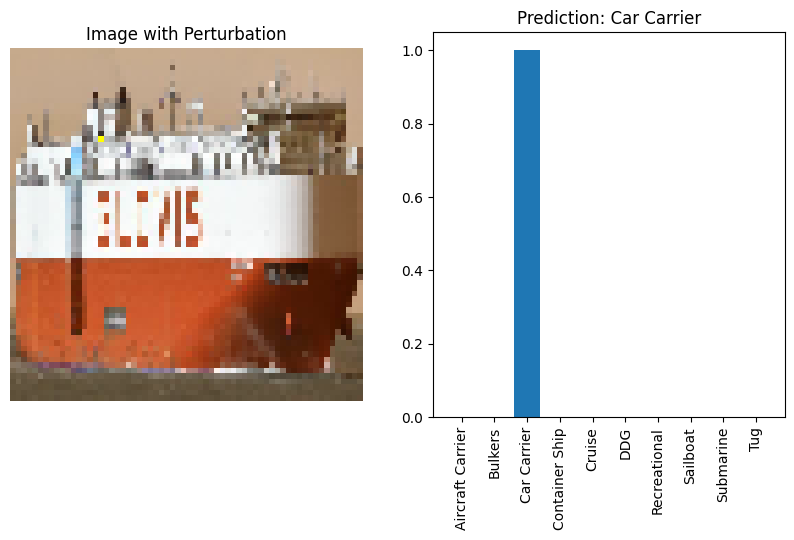

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


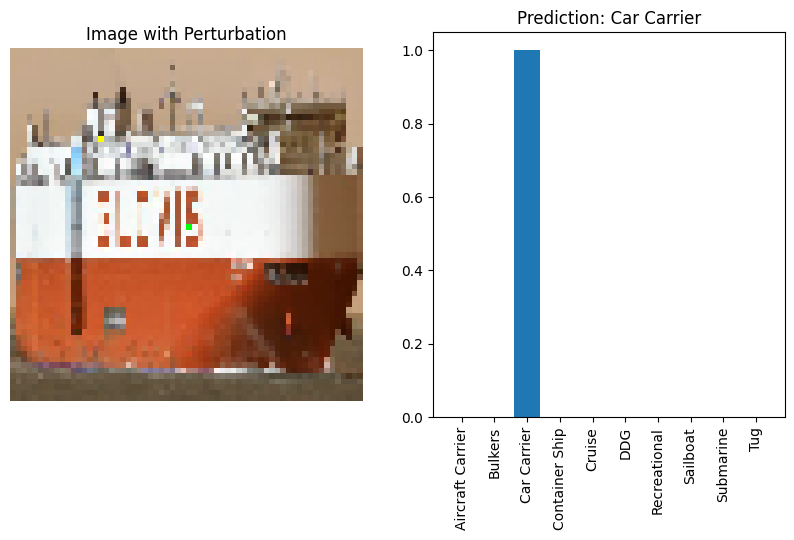

In [13]:
# Apply perturbations and plot results
for i, perturbation in enumerate(perturbations):
    perturbed_images = perturb_image(perturbation, original_image)
    for img in perturbed_images:
        plot_image_with_predictions(img, model, title=f"Perturbation {i + 1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


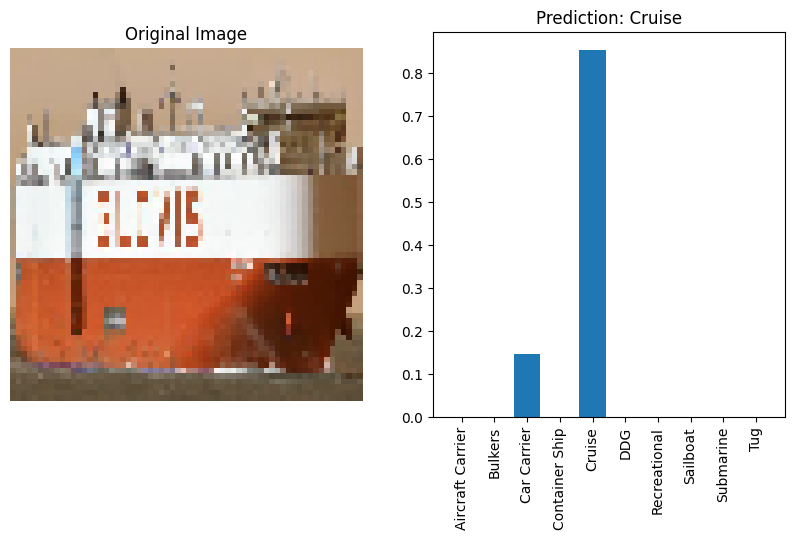

In [14]:
# Visualize original image and its prediction
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')
original_pred = model.predict(np.expand_dims(original_image, axis=0))
original_class_id = np.argmax(original_pred)
plt.subplot(1, 2, 2)
plt.title(f"Prediction: {ClassNames[original_class_id]}")
plt.bar(range(len(original_pred[0])), original_pred[0])
plt.xticks(range(len(original_pred[0])), ClassNames, rotation=90)
plt.show()
